In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random
using DelimitedFiles
using ForwardDiff
using HaltonSequences

# Framework
We define the cost function to be the following: 
\begin{equation}
	J(u):=\mathbb{E}[\int^T_0 r(x_t,u_t)dt +  \Phi(X_T)]
\end{equation}
where $X_t$ is defined through the following form: 
\begin{equation}
	X_t=X_0 + \int^t_0 f(X_s,u_s) ds + \int^t_0 g(u_s) dW_s, \  0 \leq s \leq T
\end{equation}
and $u_s$ is a deterministic control. 

In our paper, we adopt our noval SGD method.
where $(Y^k_n ,Z^k_n)$ are defined as follows: 
\begin{align}
	y^k_n &=y^{k}_{n+1}+h \big( f'_x(x^k_n,u^k_n) y^{k}_{n+1} + r'_x(x^k_n,u^k_n) \big)  \label{y_sch}  \\
	z^k_n &= \frac{y^{k}_{n+1} \sqrt{h} w_n^k}{h} \label{z_sch} 
\end{align}
where $x^k_n$ is simply one sample simulation under the control $\lbrace u^k_n \rbrace^{N-1}_{n=0}$

And the sample-wise SGD stochastic Maximum princuple gives the following updating procedure for the control
\begin{align}
	u^{k+1}_n=P_{K_N}\Bigg( u^k_n-\eta_k \Big( f_u(X_n^k,u^k_{t_n})^TY^k_n +g_u(X_n^k,u^k_{t_n})^TZ^k_n+ r'_u(X^k_n,u^k_{t_n})\Big) \Bigg) \label{SGD}
\end{align}

We make the following strong convexity assumption on the cost functional $J$: 
for some constant $\lambda>0$, and any two controls $v,w \in K$:
\begin{equation}
	\langle J'(v)-J'(w),v-w \rangle \geq \lambda ||v-w||_2^2
\end{equation}
Equivalently, one also have the following inequality: 
\begin{align}
	J(v)-J(w) \geq \langle J'(w), v-w \rangle + \frac{\lambda}{2}||v-w||^2_2
\end{align}


Also, from \cite{hui}, we have the following $C_L$-smoothness result for $J$: 
\begin{equation}
	\int^T_0 |J_t'(v)-J_t'(w)|^2 dt \leq C_L \int^T_0 |v_t-w_t|^2 dt 
\end{equation}
which is, in a more compact notation:
\begin{equation} \label{lip_vw}
	|| J'(v)-J'(w)||_2^2 \leq  C_L||v-w||^2_2 
\end{equation}

Assume that all the assumptions made in Lemma \ref{standard_new} are true. 
Take $\eta_k$ that satisfies the assumptions in Theorem \ref{standard}, then for large K,
assuming the optimal control $u^*$ is bounded, 
then the following holds: 
	\begin{equation}
		\mathbb{E}[|| u^{K+1}-u^{*}||^2_2 ] \leq C\frac{N}{K} + C N^{-1}
	\end{equation}



In [2]:
function bdrift(u,r)
    l=u.-r;
    return l
end

function bx(u)
    return 0
end

function bu(u)
    return 1
end

### The diffusion term
function sig(u)
    l=σ*u
    return l
end

function sigx(x)
    return 0
end

function sigu(u)
    return σ
end

function fx(x,xs)
    l=x.-xs
    return l
end

function fu(u)
    l=u
    return l
end


fu (generic function with 1 method)

In [3]:
function denomFrac(tvec)
    return (σ^2.0.+1.0.+σ^2*T)./(1.0.+σ^2.0.+σ^2*(T.-tvec))
end

function denom(tvec)
    return 1.0./(1.0.+σ^2.0.+σ^2*(T.-tvec))
end
####

T=1.0;
σ=0.5;
αT=log.(1.0+ σ^2/(1.0+σ^2)*T)/(σ^2+log.(1.0+ σ^2/(1.0+σ^2)*T)); 


####
XT1=T^2/2.0*αT
function xE1(tvec,denfrac)
    res=tvec.+(T.^2.0./(2*σ^2) -XT1./σ^2 )*log.(denfrac)
    return res
end

function rt1(uex,den)
    return 0.5*(-tvec.^2).*den
end

function uex1(tvec,den)
    res=( 0.5*(T^2.0.-tvec.^2).-XT1 ).*den
    return res
end


########

####
XT2=sin(T)*αT

function xE2(tvec,denfrac)
    res=cos.(tvec).+(sin(T)./(σ^2).- XT2./(σ^2))*log.(denfrac)
    return res
end

function rt2(uex,den)
    return -sin.(tvec).*den
end

function uex2(tvec,den)
    res=(sin.(T).-sin.(tvec).-XT2).*den
    return res
end
########

########
XT3=0.5*αT

function xE3(tvec,denfrac)
    res=-0.5*exp.(T.-tvec).+(1.0./(2*(σ^2)).-XT3/σ^2  )*log.(denfrac)
    return res
end

function rt3(uex,den)
    return -0.5*exp.(T.-tvec).*den
end

function uex3(tvec,den)
    res=(-0.5*exp.(T.-tvec).+0.5.-XT3).*den
    return res
end
######

#####
XT4=1.0/3.0*T^3*αT

function xE4(tvec,denfrac)
    res=tvec.^2.0.+(T^3.0./(3*(σ^2)).-XT4/σ^2)*log.(denfrac)
    return res
end

function rt4(uex,den)
    return -1/3.0.*tvec.^3.0.*den
end

function uex4(tvec,den)
    res=(1.0/3.0.*(T.-tvec.^3).-XT4).*den
    return res
end
######

#####
XT5=log.(1+T)*αT
function xE5(tvec,denfrac)
    res=1.0./(1.0.+tvec).+(log.(1.0.+T)./(σ^2).-XT5/σ^2 )*log.(denfrac)
    return res
end

function rt5(uex,den)
    return -log.(1.0.+tvec).*den
end

function uex5(tvec,den)
    res=(log.(1.0.+T).-log.(1.0.+tvec).-XT5).*den
    return res
end

######
XT6=cos(2*pi*T)*αT
function xE6(tvec,denfrac)
    res=-pi2*sin.(pi2*tvec).+(cos.(pi2*T)./((σ^2)).-XT6/σ^2)*log.(denfrac)
    return res
end

function rt6(uex,den)
    return -cos.(pi2*tvec).*den
end

function uex6(tvec,den)
    res=(-cos.(pi2*tvec).+cos.(pi2*T) .-XT6).*den
    return res
end

#####
XT7=tan(T)*αT
function xE7(tvec,denfrac)
    res=sec.(tvec).^2.0.+ (tan.(T)/(σ^2).-XT7/σ^2 ).*log.(denfrac)
    return res
end

function rt7(uex,den)
    return -tan.(tvec).*den
end

function uex7(tvec,den)
    res= (tan.(T).-tan.(tvec) .-XT7 ).*den
    return res
end

######
function xE8(tvec,den)
    """Defines the exact solution of X"""
    res=tvec./(2*σ^2).-(1.0./(2*σ^4))*log.( (σ^2*T.+1.0)./(σ^2*(T.-tvec).+1.0) ) .+1.0
    return res
end

function rt8(ue,den)
    return ue./2; 
end
function uex8(tvec,denfrac)
    """Defines the exact solution of u"""
    res=(T.-tvec)./(σ^2*(T.-tvec).+1.0)
    return res
end

uex8 (generic function with 1 method)

In [4]:
function uexact(t,den)
    u1=uex1(t,den);
    u2=uex2(t,den);
    u3=uex3(t,den); 
    u4=uex4(t,den); 
    u5=uex5(t,den);
    u6=uex6(t,den);
    u7=uex7(t,den); 
    u8=uex8(t,den); 
    temp=hcat(u1,u2,u3,u4,u5,u6,u7,u8)
    return transpose(temp)[:,1:N]
end

function rt(t,den,uexx8)
    u1=rt1(t,den);
    u2=rt2(t,den);
    u3=rt3(t,den); 
    u4=rt4(t,den); 
    u5=rt5(t,den);
    u6=rt6(t,den);
    u7=rt7(t,den); 
    u8=rt8(uexx8,den); 
    temp=hcat(u1,u2,u3,u4,u5,u6,u7,u8)
    return transpose(temp)[:,1:N]
end

function xexact(t,denfrac)
    u1=xE1(t,denfrac);
    u2=xE2(t,denfrac);
    u3=xE3(t,denfrac);
    u4=xE4(t,denfrac); 
    u5=xE5(t,denfrac);
    u6=xE6(t,denfrac);
    u7=xE7(t,denfrac);
    u8=xE8(t,denfrac); 
    temp=hcat(u1,u2,u3,u4,u5,u6,u7,u8)
    return transpose(temp)[:,1:N]
end

xexact (generic function with 1 method)

In [5]:
function X_sample(uvec)
    """
    Samples one X path according to the control
    """
    uVec=uvec;
    nd,n=size(uvec); 
    xvec=zeros(nd,n+1); 
    xvec[:,1]=x0;
    wvec=[]; 
    for i in collect(2:1:(n+1))
        rd=rand(d,8);
        push!(wvec,rd)
        xvec[:,i]=xvec[:,i-1].+bdrift(uVec[:,i-1],rvec[:,i-1])*h+sig(uvec[:,i-1])*sqrth.*rd
    end
    return xvec,wvec
end
# wvec[:,i-1]=rd; 

In [105]:
function YZ(xvec,uvec,wvec)
    """
    Returns one backward sample according to the forward sample of X and the corresponding control. 
    """
    wvec_temp=wvec; 
    nd,Ny=size(xvec)  #length(xvec);
    nd,Nz=size(uvec); 
    
    ytemp=zeros(nd,Ny); ztemp=zeros(nd,Nz);    
    " according to our scheme, the terminal condition of yT is not 0 anymore " 
    
    y_term=xvec[:,end]; 
    y_term[end]=0.0; 
    ytemp[:,end]=y_term; 
    
    
    for i in collect(Nz:-1:1)
        ztemp[:,i]=ytemp[:,i+1].*wvec_temp[i]/sqrth; 
        ytemp[:,i]=ytemp[:,i+1].+h*( bx(uvec[i]).*ytemp[:,i+1].+fx(xvec[:,i],xstar[:,i]))
    end
    return ytemp,ztemp
end


function jcp(yvec,zvec,xvec,uvec)
    """
    Compute j'
    """
    nd,n=size(uvec); 
    temp=zeros(nd,n); 
    for i in collect(1:1:n)
        temp[:,i]=bu(xvec[:,i]).*yvec[:,i].+fu(uvec[:,i]).+sigu(uvec[:,i]).*zvec[:,i]
    end
    return temp
end

function onetraj(uVec)
    """
    Given the control, find one incident of the projection 
    """
    uvec=uVec; 
    xvec,wvec=X_sample(uvec); 
    yvec,zvec=YZ(xvec,uvec,wvec); 
    tempVec=jcp(yvec,zvec,xvec,uvec); 
    return tempVec
end

function sweep(M)
    uvec=zeros(nd,N); 
    for i in collect(1:1:M)
        uvec=uvec.-1.0/i*onetraj(uvec)
    end
    return uvec
end

function sweepData(M)
    uvec=zeros(nd,N); 
    uvecErr=[];
    for i in collect(1:1:M)
        uvec=uvec.-1.0/i*onetraj(uvec)
         if mod(i,interN)==0 
            append!(uvecErr,mean(sqrt.(sum((uex.-uvec).^2,dims=1))))     
        end

    end
    return uvecErr
end

function sweepCollect(batch)
    temp=zeros(Int(mm/interN),batch)
    for i in collect(1:1:batch)
        temp[:,i]=sweepData(mm)
    end
    return temp
end


function meanError(Niter)
   temp= zeros(Niter); 
    for i in collect(1:1:Niter)
        res=sweep(0.2*N^2); # Here 0.2 is the number that one needs to to Tune
      #  temp[i]=sqrt.(mean((uex.-res).^2,dims=2))[4] #; #sqrt(mean((uex.-res).^2));
        temp[i]=mean(sqrt.(sum((uex.-res).^2,dims=1)))
        # The error is a mean error, since the ouput should be a random variable
    end
    return mean(temp)
end

meanError (generic function with 1 method)

## Problem 
(The general setup)
 	The cost functional is given by 
 	\begin{equation}\label{problem_cost}
 		J[u]=\frac{1}{2} \int_0^T \sum^d_{i=1}\mathbb{E}[(x^i-x^{i,*})^2 ]dt +\frac{1}{2} \int_0^T \sum^d_{i=1} u^{i,2}(t) dt + \frac{1}{2} \sum^{d-1}_{i=1} (x_T^i)^2, \ K = U
 	\end{equation}
 	The forward process is given by 
 	\begin{equation}\label{diff_eqn}
 		d x^i(t) = u^i(t) -r^i(t) dt + \sigma u^i(t) dW_t \  \  	\end{equation}
 	And one needs to find $u \in K$ such that 
 	$$
 	J(u^*)=\min_{u\in K} J(u)
 	$$
 	where $u^{i,*}$ is the optimal control of this problem. 


We pick the dimension to be 8, and we pick the function $r^i, x^{i,*}$ to be the following, and $u^i_t$ can be found accordingly. 
\begin{align}
	& r^1_t := \frac{-t^2/2}{\beta_t}, \ x^{1,*}=t+(\frac{T^2}{2 \sigma^2} - \frac{X^1_T}{\sigma^2}  ) \alpha_t , \  u^1_t= \frac{-t^2/2+T^2/2-X_T^1}{\beta_t} \nonumber \\ 
	&r^2_t :=\frac{-\sin(t)}{\beta_t}, \ x^{2,*}=\cos(t) +(\frac{\sin(T)}{\sigma^2}- \frac{X^2_T}{\sigma^2} )\alpha_t , \ u^2_t :=\frac{-\sin(t)+\sin(T)-X^2_T}{\beta_t} \\ 
	&r^3_t:=-0.5\frac{\exp(T-t)}{\beta_t}, \ x^{3,*}=-0.5\exp(T-t)+(\frac{1}{2\sigma^2}- \frac{X^3_T}{\sigma^2})\alpha_t \ u^3_t:=\frac{-1/2\exp(T-t)+1/2-X^3_T}{\beta_t} \nonumber \\ 
	&r^4_t:=-\frac{t^3}{3\beta_t}, \ x^{4,*}=t^2 + (\frac{T^3}{3\sigma^2}- \frac{X^4_T}{\sigma^2})\alpha_t , \ u^4_t:=\frac{-t^3 +T^3-3X^4_T}{3\beta_t}\\
	&r^5_t:=-\frac{\ln(1+t)}{\beta_t}, \ x^{5,*}=\frac{1}{1+t}+(\frac{\ln(1+T)}{\sigma^2}- \frac{X^5_T}{\sigma^2})\alpha_t , \ u^5_t:=\frac{-\ln(1+t)+\ln(1+T)-X^5_T}{\beta_t} \\
	&r^6_t:=\frac{-\cos(2 \pi t)}{\beta_t}, \ x^{6,*}=-2 \pi\sin(t)+(\frac{2 \pi\cos(T)}{\sigma^2}- \frac{X^6_T}{\sigma^2})\alpha_t, \ u^6_t:=\frac{-\cos(2 \pi t)+\cos(2 \pi T)-X^6_T}{\beta_t} \nonumber \\
	&r^7_t:=-\frac{\tan(t)}{\beta_t}, \ x^{7,*}=\sec^2(t)+(\frac{\tan(T)}{\sigma^2}- \frac{X^7_T}{\sigma^2} )\alpha_t, \ u^7_t:=\frac{-\tan(t)+\tan(T)-X^7_T}{\beta_t} \nonumber	\\ 
	&r^8_t:=\frac{1}{2} \frac{T-t}{\sigma^2(T-t)+1}, \  \ x^{8,*}=\frac{t}{2 \sigma^2} -\frac{1}{2 \sigma^4} \ln\frac{1+\sigma^2 T}{1+\sigma^2(T-t)}+1,\ u^8_t:=\frac{T-t}{\sigma^2(T-t)+1} \nonumber
\end{align}
where $$\alpha_t=\ln\frac{(1+\sigma^2)+\sigma^2 T}{(\sigma^2+1)+\sigma^2(T-t)} \ , \ \beta_t=(1+\sigma^2)+\sigma^2(T-t) $$
and with $D=\ln(1+\frac{\sigma^2 T}{1+\sigma^2} )/ \big(\sigma^2+\ln(1+\frac{\sigma^2 T}{1+\sigma^2} )  \big) $
\begin{align}
	&X^1_T=\frac{T^2}{2}D, \ X^2_T=\sin(T)D, \ X^3=\frac{1}{2}D, \ X^4_T=\frac{T^3}{T}D \\ 
	&X^5_T=\ln(1+T)D, \ X^6_T=\cos(2\pi T)D, \ X^7_T=\tan(T)D
\end{align}

# Testing begins here

In [90]:
pi2=2*pi;
σ=0.5;

nd=8; x0=zeros(nd); 
N=60; #or 80?
h=1.0/N;
sqrth=sqrt(h);d=Normal();T=1.0;
tvec=(0:1:N-1)*h

denfrac=denomFrac(tvec); 
den=denom(tvec);

T=1.0;
σ=0.5;
αT=1.0/σ^2*log.(1.0+ σ^2/(1.0+σ^2)*T)/(σ^2+log.(1.0+ σ^2/(1.0+σ^2)*T)); 


xstar=xexact(tvec,denfrac); ###---The exact x^*
uex=uexact(tvec,den); ### uex--The exact solution of the control
rvec=rt(tvec,den,uex[8,:]);  ### r--used in the construction

### The mean square error is studied. 50 samples are taken

In [106]:
@time begin 
err=meanError(50)
end

 11.138668 seconds (111.07 M allocations: 10.607 GiB, 5.15% gc time, 0.61% compilation time)


0.1605262197322844

# Model Error decay


In [49]:
function linearK(x,slope) 
    step1=3; 
    val1=0.0;
    return -slope*(x.-step1).+val1 #(val2-val1)/(step2-step1)*
end

linearK (generic function with 1 method)

### Errors are computed by varying the discretization level N. 
See above computation for the example where N=60.

In [50]:
# Errors are computed and recorded.
# May vary case by case

function errorF(N)
    errors=[0.282, 0.224, 0.194, 0.175, 0.157, 0.1475, 0.1379,  0.129,  0.122]
    Steps=[20,30,40,50,60,70,80,90,100]
    return log.(errors),log.(Steps)
end


errors,steps=errorF(N);

function linearE(x)
    val1,val2=errors[1],errors[2]; 
    step1,step2=steps[1], steps[2]; 
    return -0.5*(x.-step1).+val1 #(val2-val1)/(step2-step1)*
end

linearE (generic function with 1 method)

In [51]:
errors,steps=errorF(N);
slope_line=linearE(steps);

In [17]:
#writedlm("log_steps.txt",steps)
#writedlm("log_line.txt",slope_line)
#writedlm("log_errors.txt",errors)

In [18]:
#plot1=scatter(readdlm("log_steps.txt"),readdlm("log_errors.txt"),label="Error",legendfontsize=15,xtickfontsize=15,ytickfontsize=15,
#xguidefontsize=16,yguidefontsize=16,legend=:topright)
#plot!(steps,readdlm("log_line.txt"),label="Slope 0.5")
#title!("Error Decay")
#xlabel!("log Steps")
#ylabel!("Log Error")

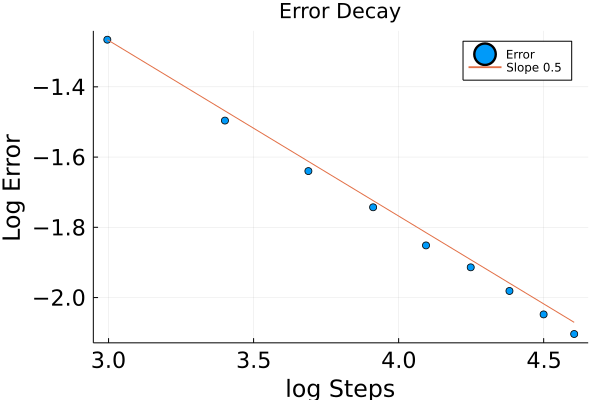

In [52]:
#Here the diffusion is \sigma=0.8
plot1=scatter(steps,errors,label="Error",legendfontsize=15,xtickfontsize=15,ytickfontsize=15,
xguidefontsize=16,yguidefontsize=16,legend=:topright)
plot!(steps,slope_line,label="Slope 0.5")
title!("Error Decay")
xlabel!("log Steps")
ylabel!("Log Error")
#png(plot1,"high_dim_decay.png")

# Plots for control

In [111]:
@time begin
ures=sweep(0.2*60^2); ##--- By increasing this value, one will obtain 
end

  0.232623 seconds (2.22 M allocations: 217.011 MiB, 5.29% gc time)


8×60 Matrix{Float64}:
  0.166164   0.19985     0.14987   …  -0.133754   -0.119483   -0.153004
  0.268342   0.308388    0.25955      -0.225165   -0.273485   -0.321651
 -0.639736  -0.381591   -0.694653     -0.20196    -0.131316   -0.19738
  0.100637   0.0782083   0.102792     -0.0730078  -0.0866169  -0.0826664
  0.248784   0.286866    0.247798     -0.202487   -0.248104   -0.196224
 -0.288994  -0.160124   -0.233509  …  -0.343567   -0.339826   -0.2549
  0.622336   0.582075    0.42687      -0.456015   -0.44798    -0.551373
  0.8478     0.725855    1.10507       0.0559669   0.0366819   0.0166574

In [112]:
#ures1=sweep(5*N^2); 
#ures2=sweep(5*N^2); 
#ures3=sweep(5*N^2); 
#ures4=sweep(5*N^2); 

In [113]:
#ures=(ures1)/1.0;

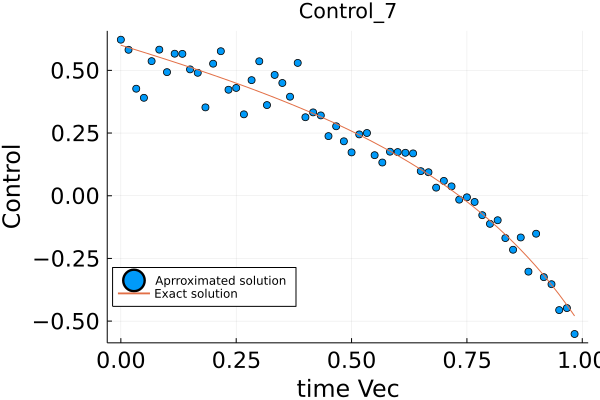

In [114]:
control_plt=scatter(tvec,ures[7,:],label="Aprroximated solution",legendfontsize=15,xtickfontsize=15,ytickfontsize=15,
xguidefontsize=16,yguidefontsize=16,legend=(0.1, 0.2)) #legend=(0.42, 0.3)
plot!(tvec,uex[7,:],label="Exact solution")
title!("Control_7")
xlabel!("time Vec")
ylabel!("Control")
#png(control_plt,"control8.png")

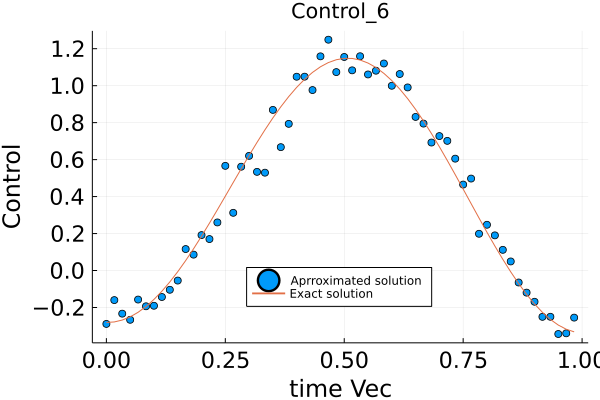

In [115]:
control_plt2=scatter(tvec,ures[6,:],label="Aprroximated solution",legendfontsize=15,xtickfontsize=15,ytickfontsize=15,
xguidefontsize=16,yguidefontsize=16,legend=(0.4, 0.2)) #legend=(0.42, 0.3)
plot!(tvec,uex[6,:],label="Exact solution")
title!("Control_6")
xlabel!("time Vec")
ylabel!("Control")

### Saving code

In [57]:
#writedlm("ures.txt",ures)
#ures=readdlm("ures.txt")

# Iteration K decay

In [58]:
mm=N^3; interN=10; batch=10;

In [59]:
# May take some time
@time begin 
dvec=sweepCollect(batch);
dvv=mean(dvec,dims=2)[:,1];
end

664.058069 seconds (6.66 G allocations: 636.888 GiB, 4.78% gc time)


21600-element Vector{Float64}:
 7.979861214206726
 3.8532384438215237
 2.3613994895700143
 1.6970821702660412
 1.3244765469992155
 1.080653172324418
 0.9187301728358241
 0.8017451916147806
 0.7240270740031622
 0.6503648100192471
 0.5983354374587274
 0.5499380417012885
 0.5180668827283686
 ⋮
 0.026587311230898247
 0.02658446885821189
 0.026585037390920795
 0.02658236833163686
 0.026581361112873514
 0.02658069187200023
 0.026580272471421872
 0.026581397849699893
 0.02658379924247175
 0.02658383614328657
 0.026584700958452324
 0.026585278052053234

In [60]:
function linearK(x,slope) 
    step1=3; 
    val1=-0.03;
    return -slope*(x.-step1).+val1 #(val2-val1)/(step2-step1)*
end

linearK (generic function with 1 method)

In [61]:
Initial=180; 
linepts=log.(collect(Initial:interN:mm-150000));
pts=linearK(linepts,0.5); ## --- The decay rate is set to be -0.5

In [62]:
decayX=log.(collect(Initial:10:mm)); 
decayY=log.(dvv[18:end]);
mycolor = theme_palette(:auto).colors.colors[1]

In [68]:
#exp.(decayX[1:9:20]), exp.(decayX[30:15:40]),exp.(decayX[60:40:120])

In [69]:
#exp.(decayX[160:80:200]), exp.(decayX[300:160:400]),exp.(decayX[700:320:800])

In [70]:
#exp.(decayX[1440:640:2000]), exp.(decayX[2800:3200:8000]),exp.(decayX[12000:8000:20000])

In [66]:
x_coordinate_dots=vcat(decayX[1:10:20],decayX[30:15:40],decayX[60:40:120],decayX[160:80:200],decayX[300:160:400],decayX[700:320:800],
decayX[1440:640:2000],decayX[2800:3200:8000],decayX[12000:8000:20000]); 
y_dots=vcat(decayY[1:10:20],decayY[30:15:40],decayY[60:40:120],decayY[160:80:200],decayY[300:160:400],decayY[700:320:800],
decayY[1440:640:2000],decayY[2800:3200:8000],decayY[12000:8000:20000]); 


In [1]:
#writedlm("dots_on_curve_Xcoord.txt",x_coordinate_dots);
#writedlm("dots_on_curve_Ycoord.txt",y_dots);
#writedlm("curve_Xcoord.txt",decayX);
#writedlm("curve_Ycoord.txt",decayY);
#writedlm("straight_line_X.txt",linepts);
#writedlm("straight_line_Y.txt",pts)

#### Fix N=60, increase K. 
One observes that since the error is 
$$\sim (C_1 \frac{1}{\sqrt{N}} + C_2 \sqrt{\frac{N}{K}})$$

One can observe that the decay stops due to the term $\frac{1}{\sqrt{N}}$. Starting with some $K_0$, as one increases $K$, the error begins to decay, and the rate of decay is close to $-0.5$.

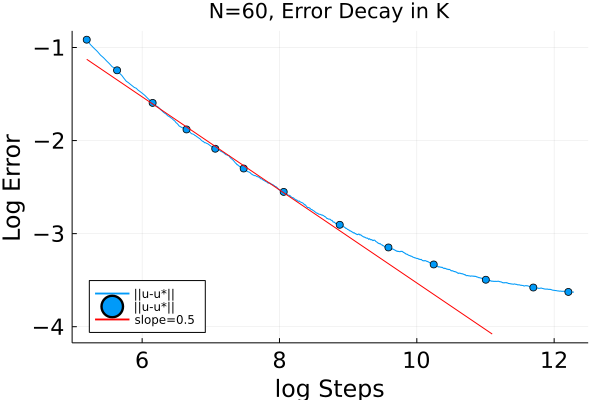

In [67]:
plotDecay=plot(decayX, decayY,label="||u-u*||",legendfontsize=15,xtickfontsize=15,ytickfontsize=15,
xguidefontsize=16,yguidefontsize=16,legend=:bottomleft,color=mycolor)
scatter!(decayX[1:10:20],decayY[1:10:20], color=mycolor, label="||u-u*||" )
scatter!(decayX[30:15:40],decayY[30:15:40], color=mycolor, label=false ) 
scatter!(decayX[60:40:120],decayY[60:40:120], color=mycolor, label=false )
scatter!(decayX[160:80:200],decayY[160:80:200], color=mycolor, label=false )
scatter!(decayX[300:160:400],decayY[300:160:400], color=mycolor, label=false )
scatter!(decayX[700:320:800],decayY[700:320:800], color=mycolor, label=false )
scatter!(decayX[1440:640:2000],decayY[1440:640:2000], color=mycolor, label=false )
scatter!(decayX[2800:3200:8000],decayY[2800:3200:8000], color=mycolor, label=false )
scatter!(decayX[12000:8000:20000],decayY[12000:8000:20000], color=mycolor, label=false )


#scatter!(decayX[1:150:end],decayY[1:150:end], color=mycolor, label=false ) 
plot!(linepts,pts, label="slope=0.5", color="red")
title!("N=60, Error Decay in K")
xlabel!("log Steps")
ylabel!("Log Error")

In [45]:
#png(plotDecay,"N60_batchCorrected.png")

In [58]:
#writedlm("dvv_interN10_N60.txt",dvv)
#dvv=readdlm("dvv_interN10_N60.txt")

# Model Error Decay

control_plt=scatter(tvec,ures[6,:],label="Numerical sol",legendfontsize=9,xtickfontsize=15,ytickfontsize=15,
xguidefontsize=16,yguidefontsize=16,legend=:topright)
plot!(tvec,uex[6,:],label="Exact solution")
title!("Control")
xlabel!("time Vec")
ylabel!("Control")